# Social Networks and Recommendation Systems

## Project 10

Adrian Stańdo

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)

### Implementing spectral clustering algorithm

In [3]:
from sklearn.cluster import KMeans

In [4]:
def spectral_clustering(adjacency_matrix, num_clusters):
    # laplacian matrix
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    laplacian_matrix = degree_matrix - adjacency_matrix

    if num_clusters is not None:
        # take the first num_clusters eigenvectors
        _, eigenvectors = np.linalg.eigh(laplacian_matrix)
        selected_eigenvectors = eigenvectors[:, :num_clusters]

        # apply k-means on the eigenvectors
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(selected_eigenvectors)
        opt_k = num_clusters
    else:
        _, eigenvectors = np.linalg.eigh(laplacian_matrix)
        distortions = []
        all_labels = {}

        for k in range(2, 21):
            selected_eigenvectors = eigenvectors[:, :k]
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            l = kmeans.fit_predict(selected_eigenvectors)
            all_labels[k] = l
            distortions.append(kmeans.inertia_)

        opt_k = np.argmin(np.diff(distortions)) + 1
        labels = all_labels[opt_k]

    return opt_k, labels

### The Harry Potter network

https://github.com/efekarakus/potter-network/blob/master/data/relations.csv

In [5]:
hp_characters = pd.read_csv('./data/harry_potter_characters.csv')[['id', 'name']]
hp_relations = pd.read_csv('./data/harry_potter_relations.csv')
hp_relations = hp_relations[hp_relations['type'] == '+'][['source', 'target']]
hp = hp_relations.merge(hp_characters, left_on='source', right_on='id', how='left')[['name', 'target']]
hp.columns = ['source', 'target']
hp = hp.merge(hp_characters, left_on='target', right_on='id', how='left')[['source', 'name']]
hp.columns = ['source', 'target']
G_hp = nx.from_pandas_edgelist(hp, 'source', 'target')
G_hp.remove_edges_from(nx.selfloop_edges(G_hp))
largest_component = max(list(nx.connected_components(G_hp)), key=len)
G_hp = G_hp.subgraph(largest_component)

In [6]:
adjacency_matrix = nx.adjacency_matrix(G_hp)
num_clusters = 2
_, labels = spectral_clustering(adjacency_matrix, num_clusters)

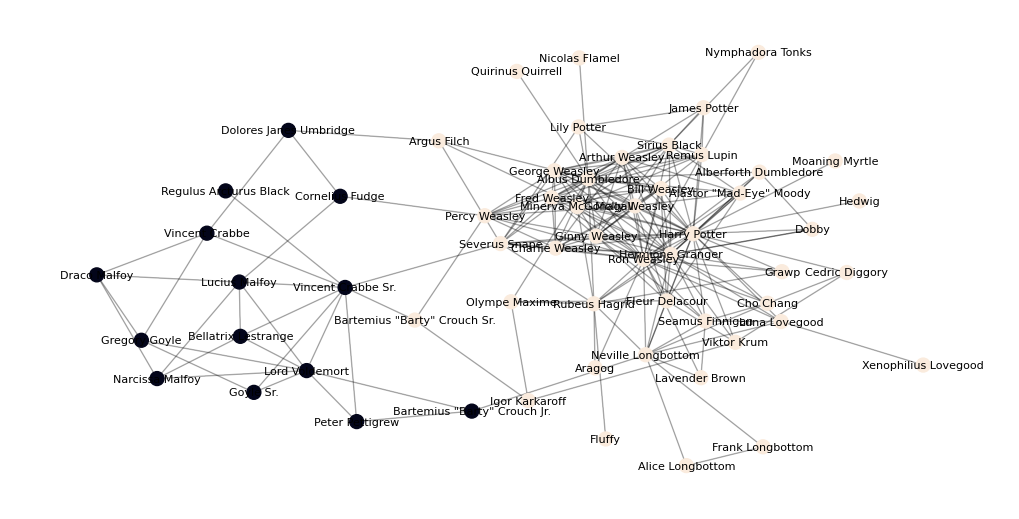

In [7]:
plt.figure(figsize=(10, 5))
pos = nx.kamada_kawai_layout(G_hp)
nx.draw(G_hp, with_labels=True, node_size=100,
        width=0.05, node_color=labels, edge_cmap=plt.cm.Blues,
        pos=pos, font_size=8)
nx.draw_networkx_edges(G_hp, pos, alpha=0.3)
plt.show()

### The SNARS competition

In [8]:
import time

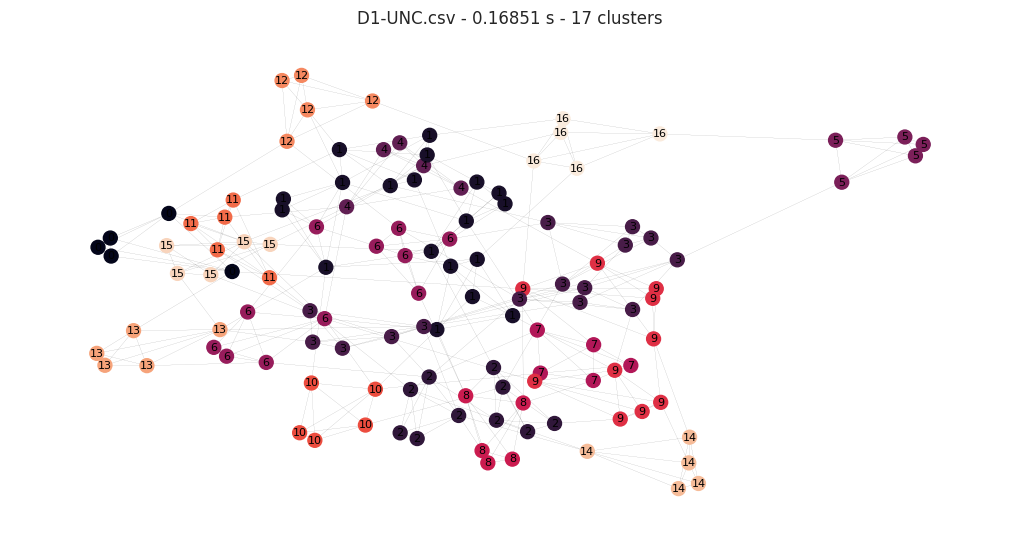

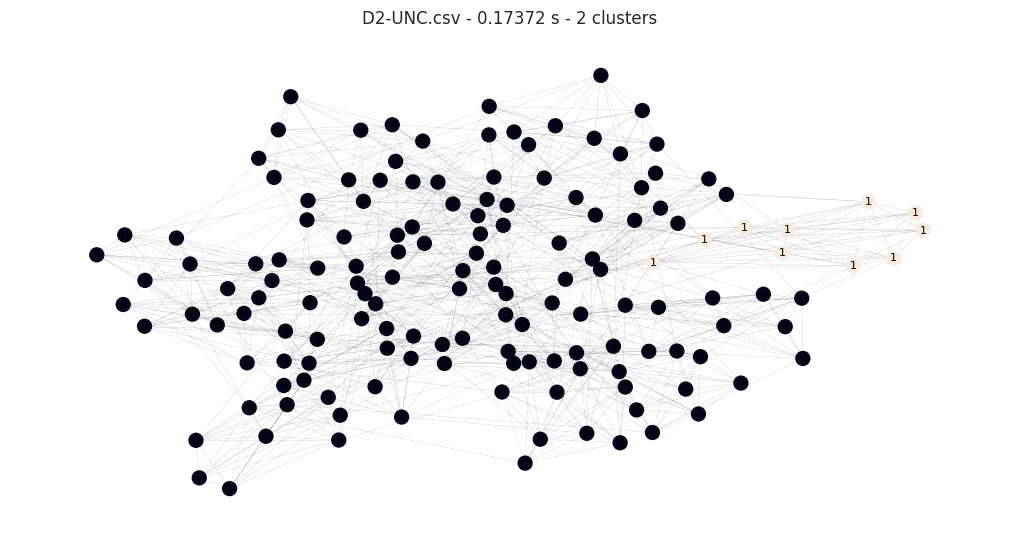

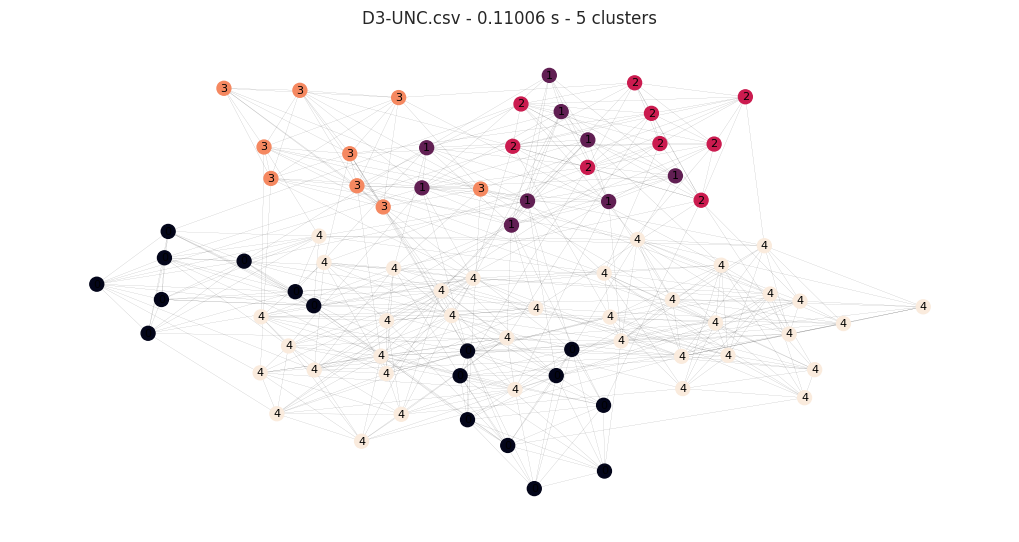

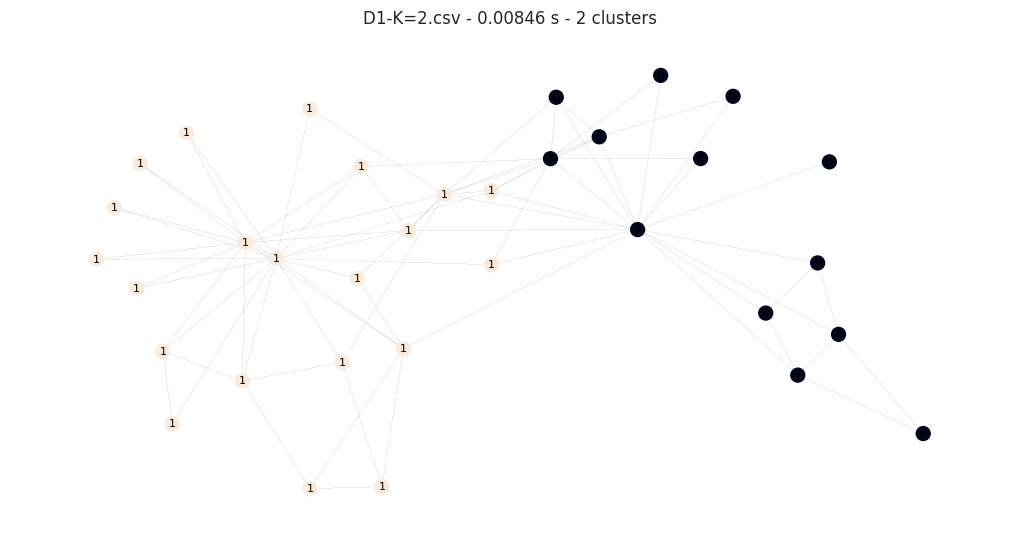

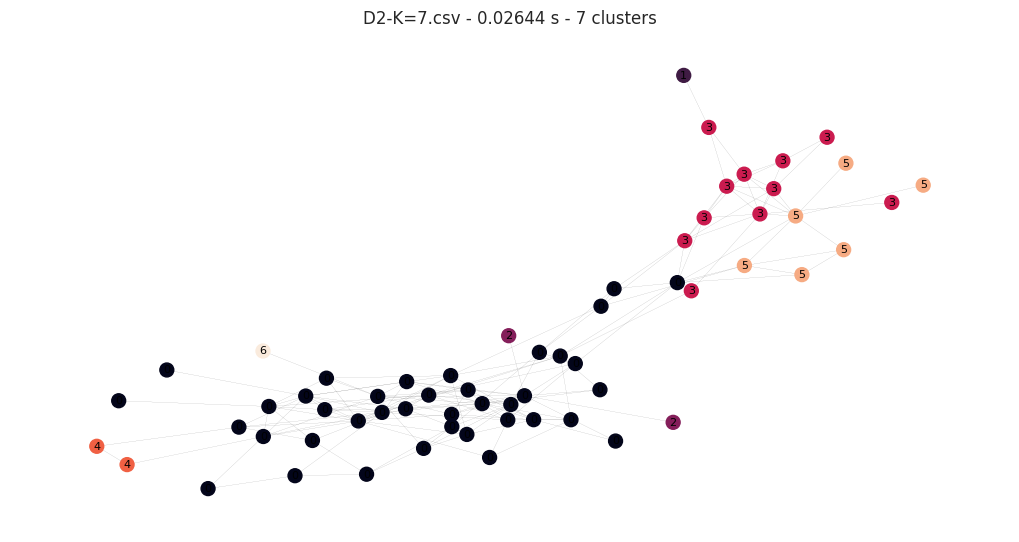

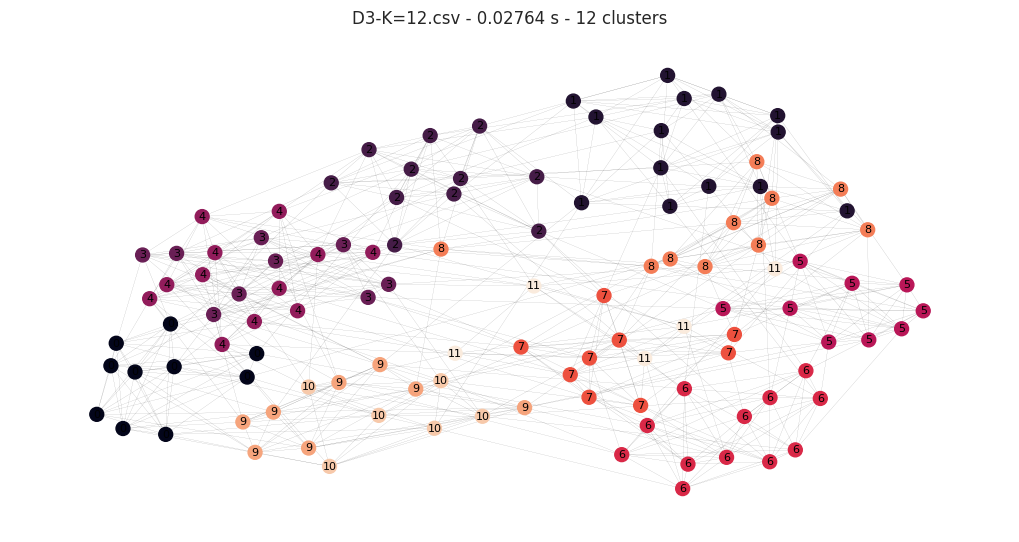

In [9]:
with open('./results/description.txt', 'w') as f:
    print('Adrian Stańdo', file=f)
    print('https://github.com/adrianstando/SNARS-competition', file=f)

    for file, num_clusters in zip(
            ['D1-UNC.csv', 'D2-UNC.csv', 'D3-UNC.csv', 'D1-K=2.csv', 'D2-K=7.csv', 'D3-K=12.csv'],
            [None, None, None, 2, 7, 12]
    ):
        adj = pd.read_csv('./data/' + file, header=None)
        G = nx.from_pandas_adjacency(adj)
        adjacency_matrix = nx.adjacency_matrix(G)

        start = time.time()
        num_clusters_final, labels = spectral_clustering(adjacency_matrix, num_clusters)
        end = time.time()

        print(f'{file}, {end-start}', file=f)

        labels_df = pd.DataFrame(labels)
        labels_df.to_csv('./results/' + file, header=False, index=True)

        node_labels = {i: label for i, label in enumerate(labels)}

        plt.figure(figsize=(10, 5))
        pos = nx.spring_layout(G)
        nx.draw(G, with_labels=False, node_size=100, width=0.05, node_color=labels, edge_cmap=plt.cm.Blues,  font_size=8, pos=pos)
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
        plt.title(f'{file} - {end-start:.5f} s - {num_clusters_final} clusters')
        plt.show()